### The plan is to train 3 models of increasing complexity. All 3 models will be trained without the use of StandardScaler.
#### Model 1: Uses temporal and consumption features.
#### Model 2: Adds weather features to Model 1.
#### Model 3: Adds household, pricing, attitudinal, behavioural, and appliance features to Model 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer, r2_score

df = pd.read_csv('6) daily_consumption_data_full.csv', parse_dates=['date'])

In [2]:
# Categorisation of input variables
weather_features = [
    'temp_max_today', 'humidity_min_today', 'humidity_max_today', 'windspeed_max_today', 'precip_sum_today', 'solarradiation_sum_today',
    'humidity_at_peak_consumption_today', 'windspeed_at_peak_consumption_today', 'precip_at_peak_consumption_today', 
    'solarradiation_at_peak_consumption_today', 'temp_range_today', 'windspeed_min_today'
]

temporal_features = [
    'is_winter', 'is_summer', 'is_autumn', 'is_weekend', 'is_holiday', 'day_of_week_sin', 
    'day_of_week_cos', 'week_of_month_sin', 'week_of_month_cos'
]

consumption_features = [
    'consumption_sum_today', 'consumption_peak_today', 'consumption_min_today', 'prev_day_peak', 'same_day_last_week_peak', 
    'avg_peak_3d', 'avg_peak_7d', 'max_peak_7d', 'max_peak_3d'
]

household_features = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'ownership_owned', 
    'ownership_rented', 'ownership_other', 'work_from_home', 'housing_house', 'housing_apartment', 
    'count_rooms', 'electric_central_heating', 'heating_manual_boiler', 'heating_thermostatic_valves', 
    'heating_auto_set_times', 'heating_auto_temp_control', 'heating_not_sure', 'uses_electric_heater'
]

pricing_features = [
    'prop_low_price', 'prop_high_price', 'tariff_at_peak_consumption_today'
]

attitudinal_and_behavioural_features = [
    'interest_in_renewable_energy', 'interest_in_microgeneration', 'climate_change_concern', 
    'lifestyle_environment', 'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'
]

appliance_features = [
    'washing_machine_fixed_schedule', 'tumble_dryer_fixed_schedule', 'dishwasher_fixed_schedule', 
    'immersion_water_heater_fixed_schedule', 'electric_oven_fixed_schedule', 'electric_hob_fixed_schedule', 
    'ironing_fixed_schedule', 'electric_shower_fixed_schedule', 'kettle_fixed_schedule', 'lighting_fixed_schedule', 
    'electric_heater_fixed_schedule', 'washer-dryer_combined_timer_use', 'washing_machine_timer_use', 
    'tumble_dryer_timer_use', 'dishwasher_timer_use', 'electric_space_heating_timer_use', 
    'washer-dryer_combined_ownership', 'washing_machine_ownership', 'tumble_dryer_ownership', 'dishwasher_ownership', 
    'electric_space_heating_ownership', 'count_low_efficiency_bulbs', 'total_refrigeration_units', 
    'count_cooking_appliances', 'count_laundry_appliances', 'count_kitchen_appliances', 
    'count_heating_water_appliances', 'count_entertainment_devices', 'count_computing_devices', 'count_tv', 
    'tv_energy_score'
]

# Define feature sets for models
model_1_features = temporal_features + consumption_features
model_2_features = model_1_features + weather_features
model_3_features = model_2_features + household_features + pricing_features + attitudinal_and_behavioural_features + appliance_features

### Let's take a look at our target variable again

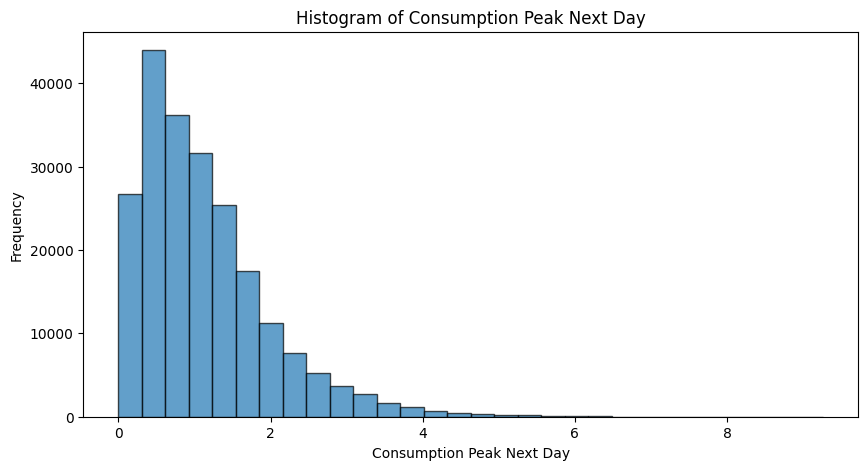

In [3]:
# Plot histogram of 'consumption_peak_next_day'
plt.figure(figsize=(10, 5))
plt.hist(df['consumption_peak_next_day'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Consumption Peak Next Day')
plt.xlabel('Consumption Peak Next Day')
plt.ylabel('Frequency')
plt.show()

### Let's apply some transformation as the target variable is skewed

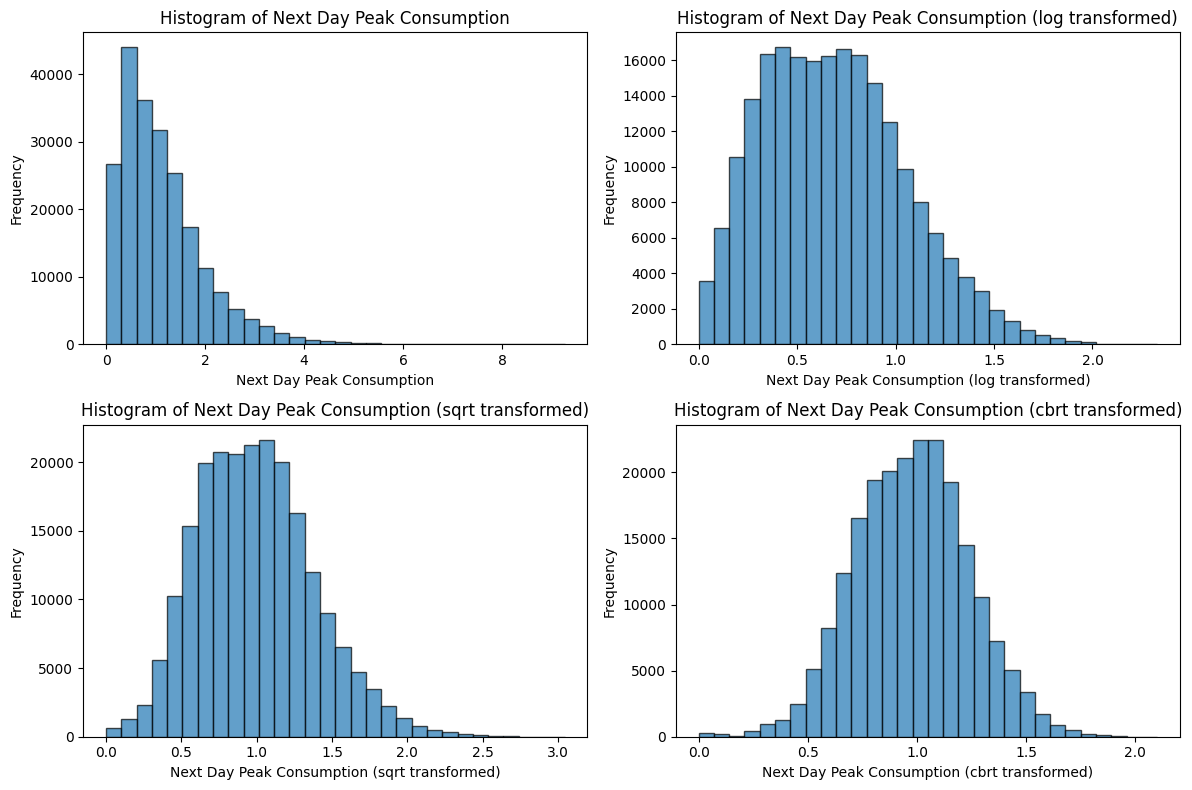

In [4]:
transformations = {
    'log_consumption_peak_next_day': np.log1p,
    'sqrt_consumption_peak_next_day': np.sqrt,
    'cbrt_consumption_peak_next_day': np.cbrt
}

for new_col, func in transformations.items():
    df[new_col] = func(df['consumption_peak_next_day'])

# Plot histograms of original and transformed 'consumption_peak_next_day'
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original data
axes[0, 0].hist(df['consumption_peak_next_day'], bins=30, edgecolor='k', alpha=0.7)
axes[0, 0].set_title('Histogram of Next Day Peak Consumption')
axes[0, 0].set_xlabel('Next Day Peak Consumption')
axes[0, 0].set_ylabel('Frequency')

# Transformed data
for ax, (new_col, _) in zip(axes.flat[1:], transformations.items()):
    transformation_name = new_col.split('_')[0]
    ax.hist(df[new_col], bins=30, edgecolor='k', alpha=0.7)
    ax.set_title(f'Histogram of Next Day Peak Consumption ({transformation_name} transformed)')
    ax.set_xlabel(f'Next Day Peak Consumption ({transformation_name} transformed)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Let's train our models using each transformation of the target variable, consumption_peak_next_day

In [5]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': randint(100, 3000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Define date ranges for folds
# Considering we only have 2013 data, we will define the folds as the following and use December as the test set
folds = [
    ('2013-01-08', '2013-08-31', '2013-09-01', '2013-09-30'),
    ('2013-01-08', '2013-09-30', '2013-10-01', '2013-10-31'),
    ('2013-01-08', '2013-10-31', '2013-11-01', '2013-11-30')
]

In [6]:
def run_model(features, df, folds, param_grid, model_name):
    def create_dataset(df, start_date, end_date):
        mask = (df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))
        X = df.loc[mask, features]
        y = df.loc[mask, ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                          'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']]
        return X, y

    def calculate_metrics(y_true, y_pred, transformation='consumption_peak_next_day'):
        if transformation == 'log_consumption_peak_next_day':
            y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
        elif transformation == 'sqrt_consumption_peak_next_day':
            y_true, y_pred = y_true ** 2, y_pred ** 2
        elif transformation == 'cbrt_consumption_peak_next_day':
            y_true, y_pred = y_true ** 3, y_pred ** 3
        
        mae = np.mean(np.abs(y_true - y_pred))
        
        non_zero = (y_true != 0)
        mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
        
        wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
        
        r2 = r2_score(y_true, y_pred)
        
        return mae, mape, wape, r2
    
    # Custom function for WAPE to use as the scoring metric for the RandomSearch
    def wape_score(y_true, y_pred):
        return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

    wape_scorer = make_scorer(wape_score, greater_is_better=False)

    def get_best_params(best_params_list, wape_scores_val):
        best_fold_index = np.argmin(wape_scores_val)
        return best_params_list[best_fold_index]

    results = {target: {'mae_scores_train': [], 'mape_scores_train': [], 'wape_scores_train': [], 'r2_scores_train': [],
                        'mae_scores_val': [], 'mape_scores_val': [], 'wape_scores_val': [], 'r2_scores_val': [],
                        'feature_importances': [], 'best_params': []} 
               for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                              'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']}

    print(f"\n--- Running {model_name} ---\n")

    for fold, (train_start, train_end, val_start, val_end) in enumerate(folds, 1):
        print(f"Fold {fold}")
        print(f"Training period: {train_start} to {train_end}")
        print(f"Validation period: {val_start} to {val_end}")
        
        X_train, y_train = create_dataset(df, train_start, train_end)
        X_val, y_val = create_dataset(df, val_start, val_end)
        
        tscv = TimeSeriesSplit(n_splits=3)
        
        for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                       'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']:
            print(f"\nTarget: {target}")
            
            model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, enable_categorical=True)
            random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                               n_iter=100, cv=tscv.split(X_train), 
                                               scoring=wape_scorer, 
                                               n_jobs=-1, random_state=1)
            random_search.fit(X_train, y_train[target])
            
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            results[target]['best_params'].append(best_params)
            
            train_predictions = best_model.predict(X_train)
            train_mae, train_mape, train_wape, train_r2 = calculate_metrics(y_train[target], train_predictions, target)
            results[target]['mae_scores_train'].append(train_mae)
            results[target]['mape_scores_train'].append(train_mape)
            results[target]['wape_scores_train'].append(train_wape)
            results[target]['r2_scores_train'].append(train_r2)
            
            val_predictions = best_model.predict(X_val)
            val_mae, val_mape, val_wape, val_r2 = calculate_metrics(y_val[target], val_predictions, target)
            results[target]['mae_scores_val'].append(val_mae)
            results[target]['mape_scores_val'].append(val_mape)
            results[target]['wape_scores_val'].append(val_wape)
            results[target]['r2_scores_val'].append(val_r2)
            
            importances = best_model.feature_importances_
            results[target]['feature_importances'].append(dict(zip(features, importances)))
            
            print(f"Training metrics for fold {fold}:")
            print(f"MAE: {train_mae:.4f}")
            print(f"MAPE: {train_mape:.4f}%")
            print(f"WAPE: {train_wape:.4f}%")
            print(f"R²: {train_r2:.4f}")
            
            print(f"Validation metrics for fold {fold}:")
            print(f"MAE: {val_mae:.4f}")
            print(f"MAPE: {val_mape:.4f}%")
            print(f"WAPE: {val_wape:.4f}%")
            print(f"R²: {val_r2:.4f}")
            
            print("Top 15 Feature importances:")
            for feature, importance in sorted(zip(features, importances), key=lambda x: x[1], reverse=True)[:15]:
                print(f"{feature}: {importance:.3f}")
            print("\n")

    for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                   'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']:
        print(f"\nResults for {target}:")
        print(f"Average Training MAE across folds: {np.mean(results[target]['mae_scores_train']):.4f}")
        print(f"Average Training MAPE across folds: {np.mean(results[target]['mape_scores_train']):.4f}%")
        print(f"Average Training WAPE across folds: {np.mean(results[target]['wape_scores_train']):.4f}%")
        print(f"Average Training R² across folds: {np.mean(results[target]['r2_scores_train']):.4f}")
        print(f"Average Validation MAE across folds: {np.mean(results[target]['mae_scores_val']):.4f}")
        print(f"Average Validation MAPE across folds: {np.mean(results[target]['mape_scores_val']):.4f}%")
        print(f"Average Validation WAPE across folds: {np.mean(results[target]['wape_scores_val']):.4f}%")
        print(f"Average Validation R² across folds: {np.mean(results[target]['r2_scores_val']):.4f}")

        avg_importances = {}
        for feature in features:
            avg_importances[feature] = np.mean([fold[feature] for fold in results[target]['feature_importances']])

        print("\nTop 15 Average feature importances across folds:")
        for feature, importance in sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)[:15]:
            print(f"{feature}: {importance:.3f}")

    test_start = '2013-12-01'
    test_end = '2013-12-30'

    X_train_final, y_train_final = create_dataset(df, df['date'].min(), pd.to_datetime(test_start) - pd.Timedelta(days=1))
    X_test, y_test = create_dataset(df, test_start, test_end)

    final_models = {}
    test_metrics = {}
    final_importances = {}

    print("\n--- Test Metrics ---")
    for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                   'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']:
        best_params = get_best_params(results[target]['best_params'], results[target]['wape_scores_val'])
        final_model = XGBRegressor(**best_params, enable_categorical=True)
        final_model.fit(X_train_final, y_train_final[target])

        test_predictions = final_model.predict(X_test)
        test_mae, test_mape, test_wape, test_r2 = calculate_metrics(y_test[target], test_predictions, target)
        print(f"\nMetrics on test set for {target}:")
        print(f"MAE: {test_mae:.4f}")
        print(f"MAPE: {test_mape:.4f}%")
        print(f"WAPE: {test_wape:.4f}%")
        print(f"R²: {test_r2:.4f}")

        final_models[target] = final_model
        test_metrics[target] = {'mae': test_mae, 'mape': test_mape, 'wape': test_wape, 'r2': test_r2}
        final_importances[target] = dict(zip(features, final_model.feature_importances_))

    print("\n--- Feature Importances ---")
    for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                   'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']:
        feature_imp = pd.DataFrame(sorted(zip(final_models[target].feature_importances_, features)), columns=['Value','Feature'])

        plt.figure(figsize=(10, min(20, len(features) * 0.3)))
        plt.barh(feature_imp['Feature'], feature_imp['Value'])
        plt.title(f'XGBoost Feature Importances - {model_name} - {target} (Trained on All Data Excluding Test Set)')
        plt.xlabel('Importance')

        for i, v in enumerate(feature_imp['Value']):
            plt.text(v, i, f' {v:.3f}', va='center')

        plt.tight_layout()
        plt.show()

    return final_models, test_metrics, final_importances


--- Running Model 1 ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30

Target: consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3331
MAPE: 56.6426%
WAPE: 29.7236%
R²: 0.7074
Validation metrics for fold 1:
MAE: 0.3372
MAPE: 63.8490%
WAPE: 33.2061%
R²: 0.5975
Top 15 Feature importances:
avg_peak_7d: 0.460
avg_peak_3d: 0.220
max_peak_7d: 0.072
max_peak_3d: 0.060
consumption_sum_today: 0.039
consumption_peak_today: 0.026
same_day_last_week_peak: 0.021
prev_day_peak: 0.015
day_of_week_sin: 0.014
is_winter: 0.011
consumption_min_today: 0.010
is_summer: 0.009
day_of_week_cos: 0.009
is_weekend: 0.009
week_of_month_cos: 0.009



Target: log_consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3375
MAPE: 50.6542%
WAPE: 30.1156%
R²: 0.6771
Validation metrics for fold 1:
MAE: 0.3326
MAPE: 55.5018%
WAPE: 32.7547%
R²: 0.5914
Top 15 Feature importances:
avg_peak_7d: 0.553
avg_peak_3d: 0.172
max_peak_3d: 0.048
consumption_sum_today

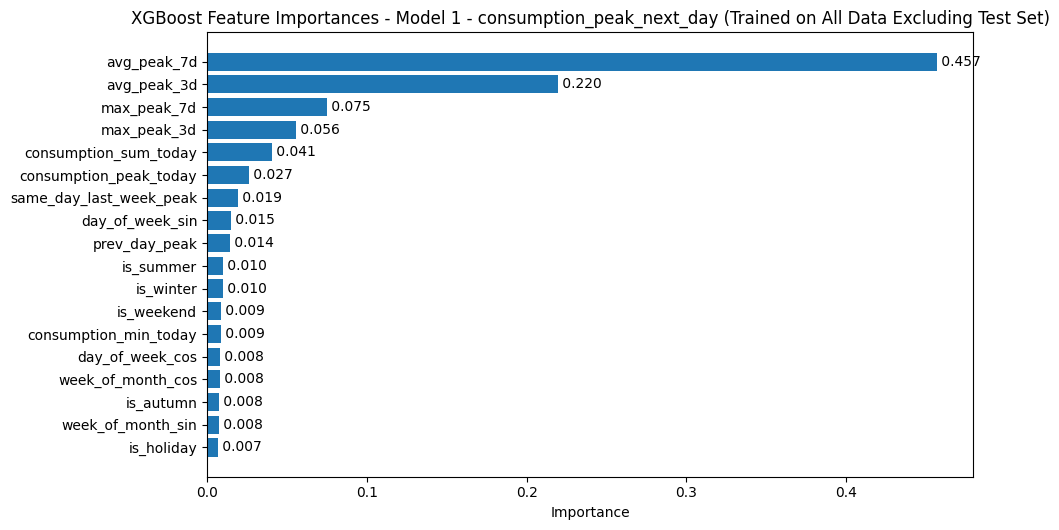

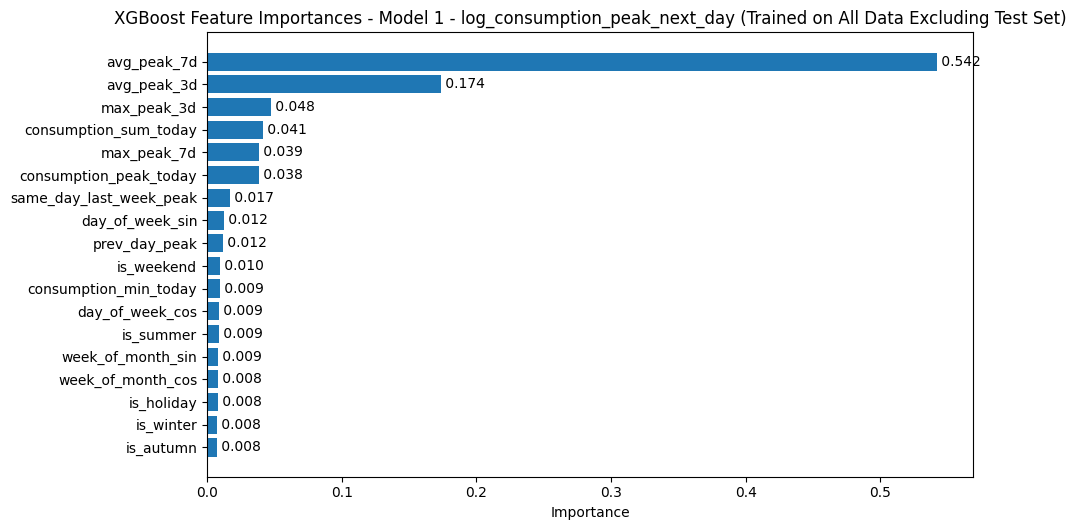

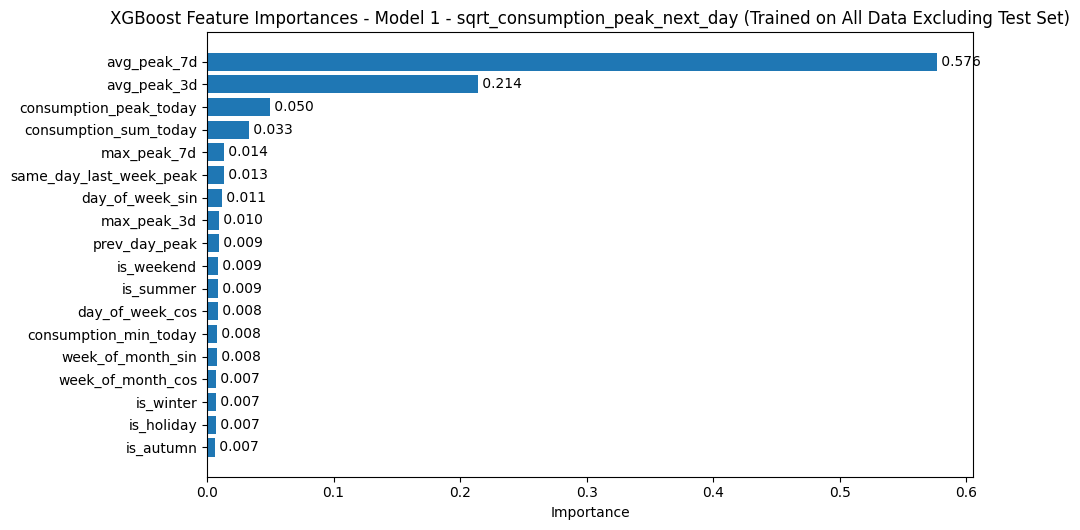

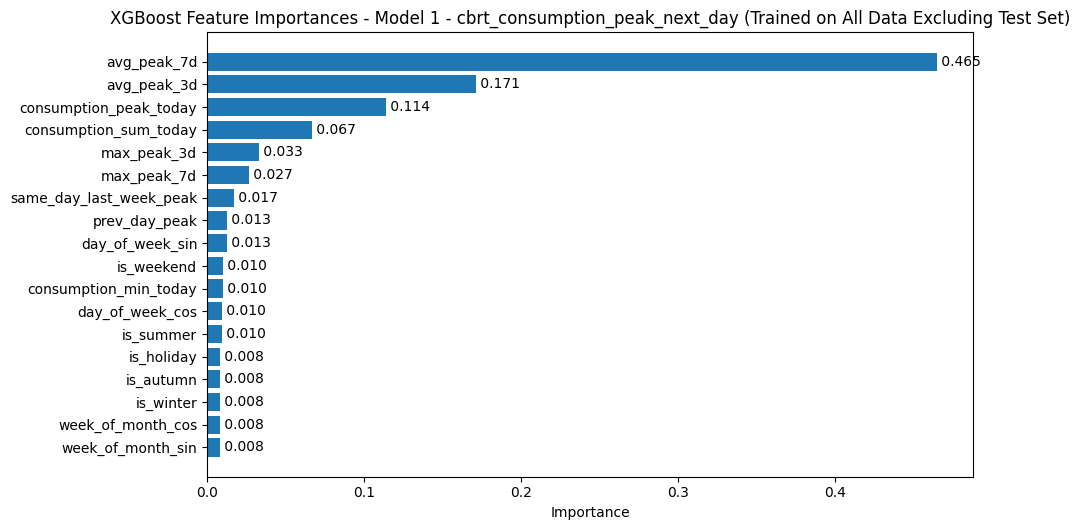


--- Running Model 2 ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30

Target: consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3435
MAPE: 60.0674%
WAPE: 30.6436%
R²: 0.6842
Validation metrics for fold 1:
MAE: 0.3377
MAPE: 64.7982%
WAPE: 33.2545%
R²: 0.5966
Top 15 Feature importances:
avg_peak_7d: 0.676
avg_peak_3d: 0.144
consumption_sum_today: 0.019
consumption_peak_today: 0.015
max_peak_7d: 0.013
same_day_last_week_peak: 0.011
day_of_week_sin: 0.010
prev_day_peak: 0.007
temp_range_today: 0.007
temp_max_today: 0.006
is_holiday: 0.006
max_peak_3d: 0.006
solarradiation_at_peak_consumption_today: 0.005
solarradiation_sum_today: 0.005
consumption_min_today: 0.005



Target: log_consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3414
MAPE: 52.0048%
WAPE: 30.4570%
R²: 0.6682
Validation metrics for fold 1:
MAE: 0.3325
MAPE: 54.9068%
WAPE: 32.7466%
R²: 0.5900
Top 15 Feature importances:
avg_peak_7d: 0.476
avg_peak_3d: 0.

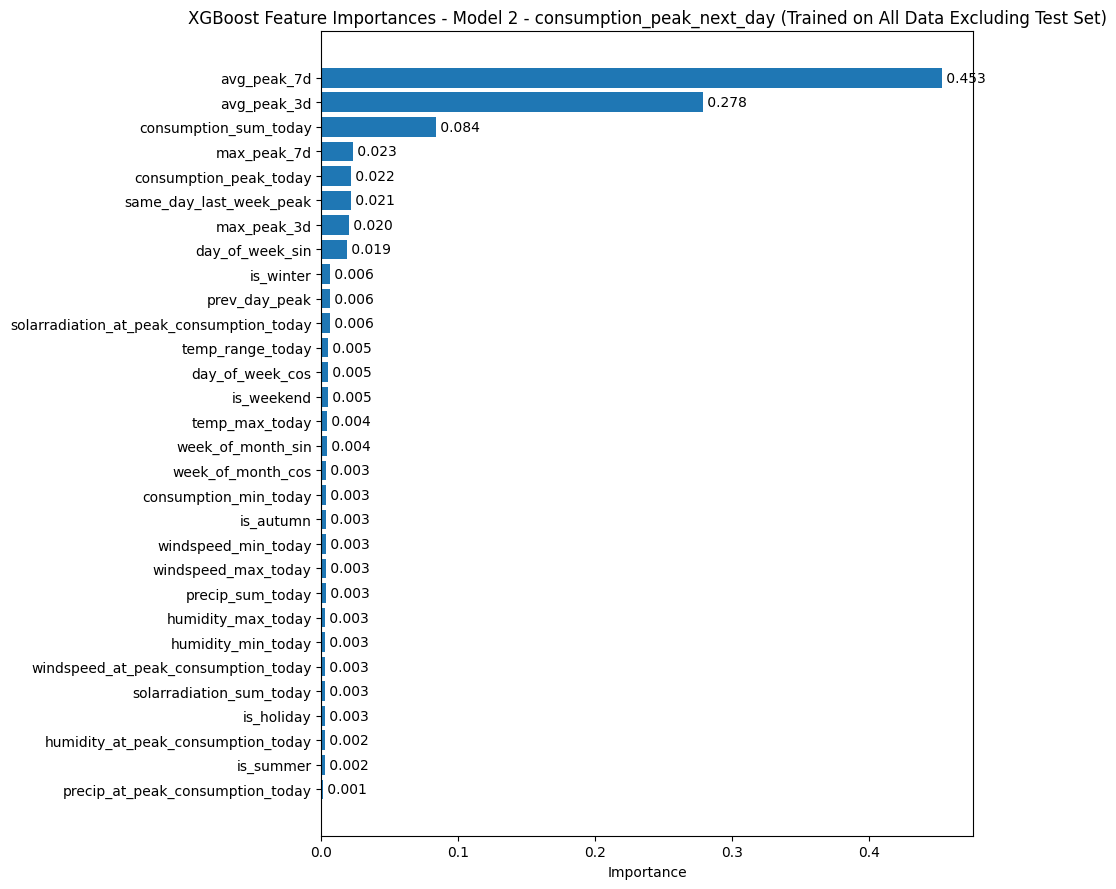

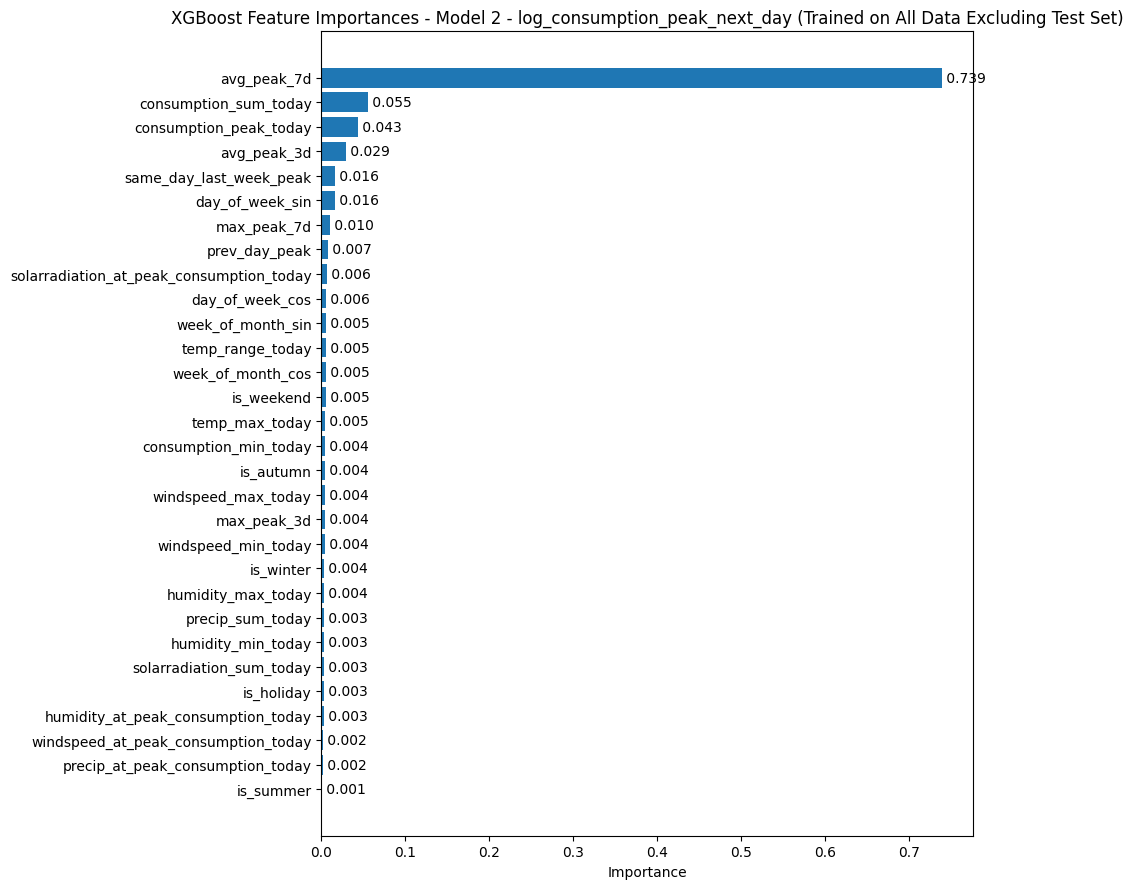

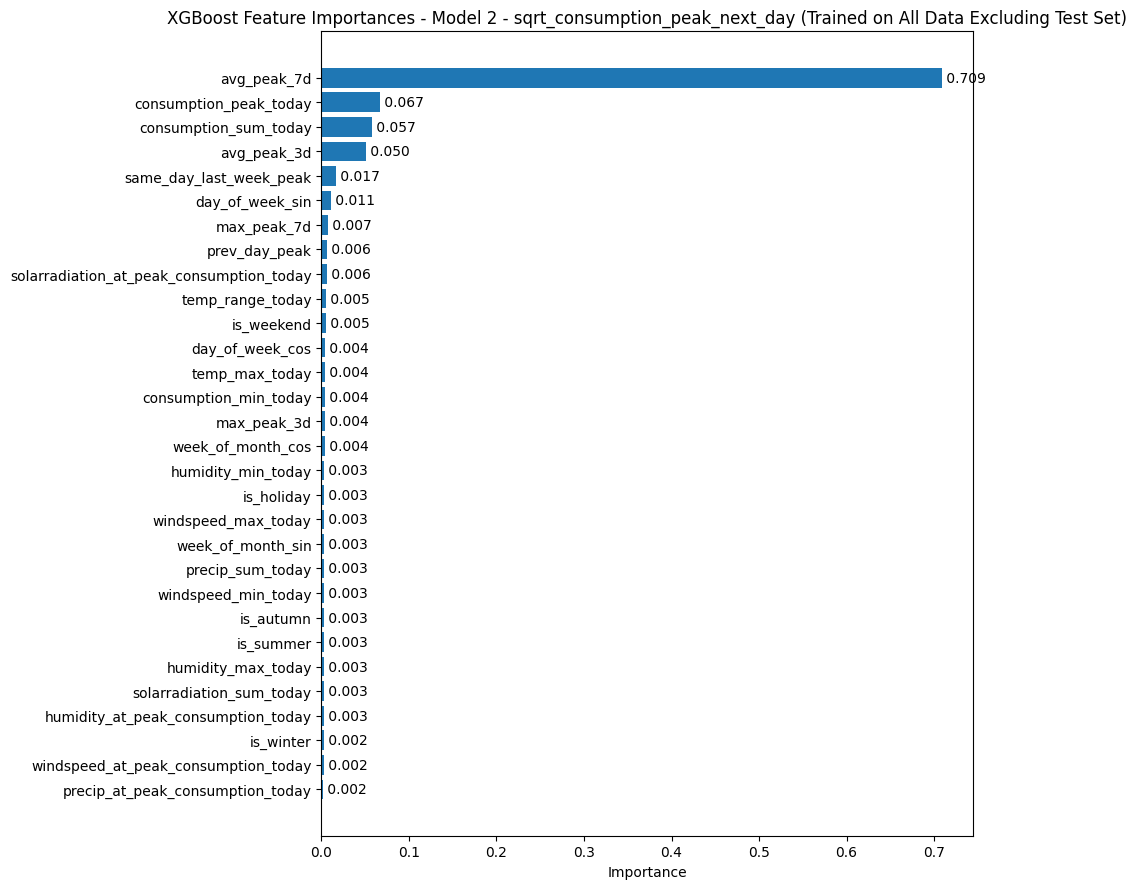

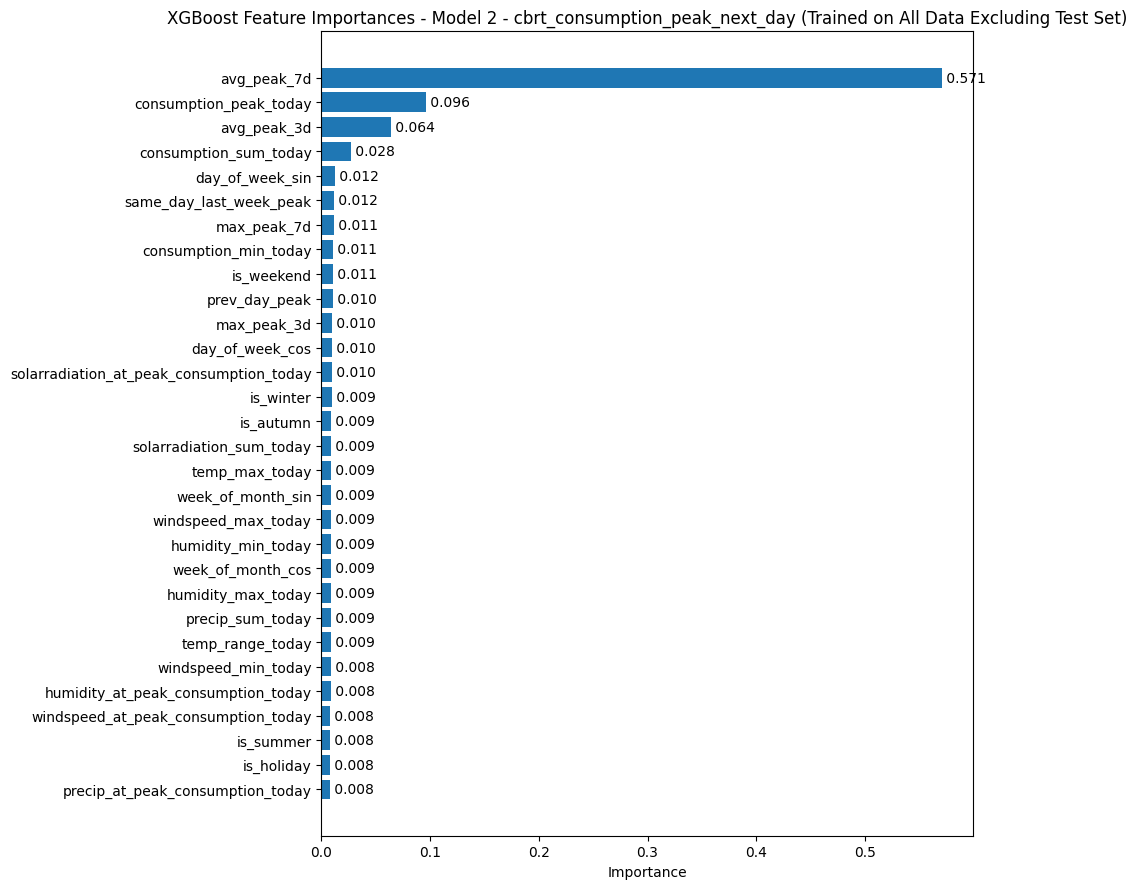


--- Running Model 3 ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30

Target: consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.2839
MAPE: 48.1370%
WAPE: 25.3292%
R²: 0.7965
Validation metrics for fold 1:
MAE: 0.3273
MAPE: 67.5115%
WAPE: 32.2302%
R²: 0.6243
Top 15 Feature importances:
avg_peak_7d: 0.355
avg_peak_3d: 0.094
max_peak_3d: 0.027
consumption_sum_today: 0.019
max_peak_7d: 0.017
consumption_peak_today: 0.015
uses_electric_heater: 0.012
ironing_fixed_schedule: 0.010
tumble_dryer_ownership: 0.010
immersion_water_heater_fixed_schedule: 0.009
count_kitchen_appliances: 0.009
day_of_week_sin: 0.008
same_day_last_week_peak: 0.008
prev_day_peak: 0.008
washing_machine_timer_use: 0.008



Target: log_consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.2756
MAPE: 39.4580%
WAPE: 24.5921%
R²: 0.7897
Validation metrics for fold 1:
MAE: 0.3205
MAPE: 55.2706%
WAPE: 31.5642%
R²: 0.6211
Top 15 Feature importances:
avg_peak_

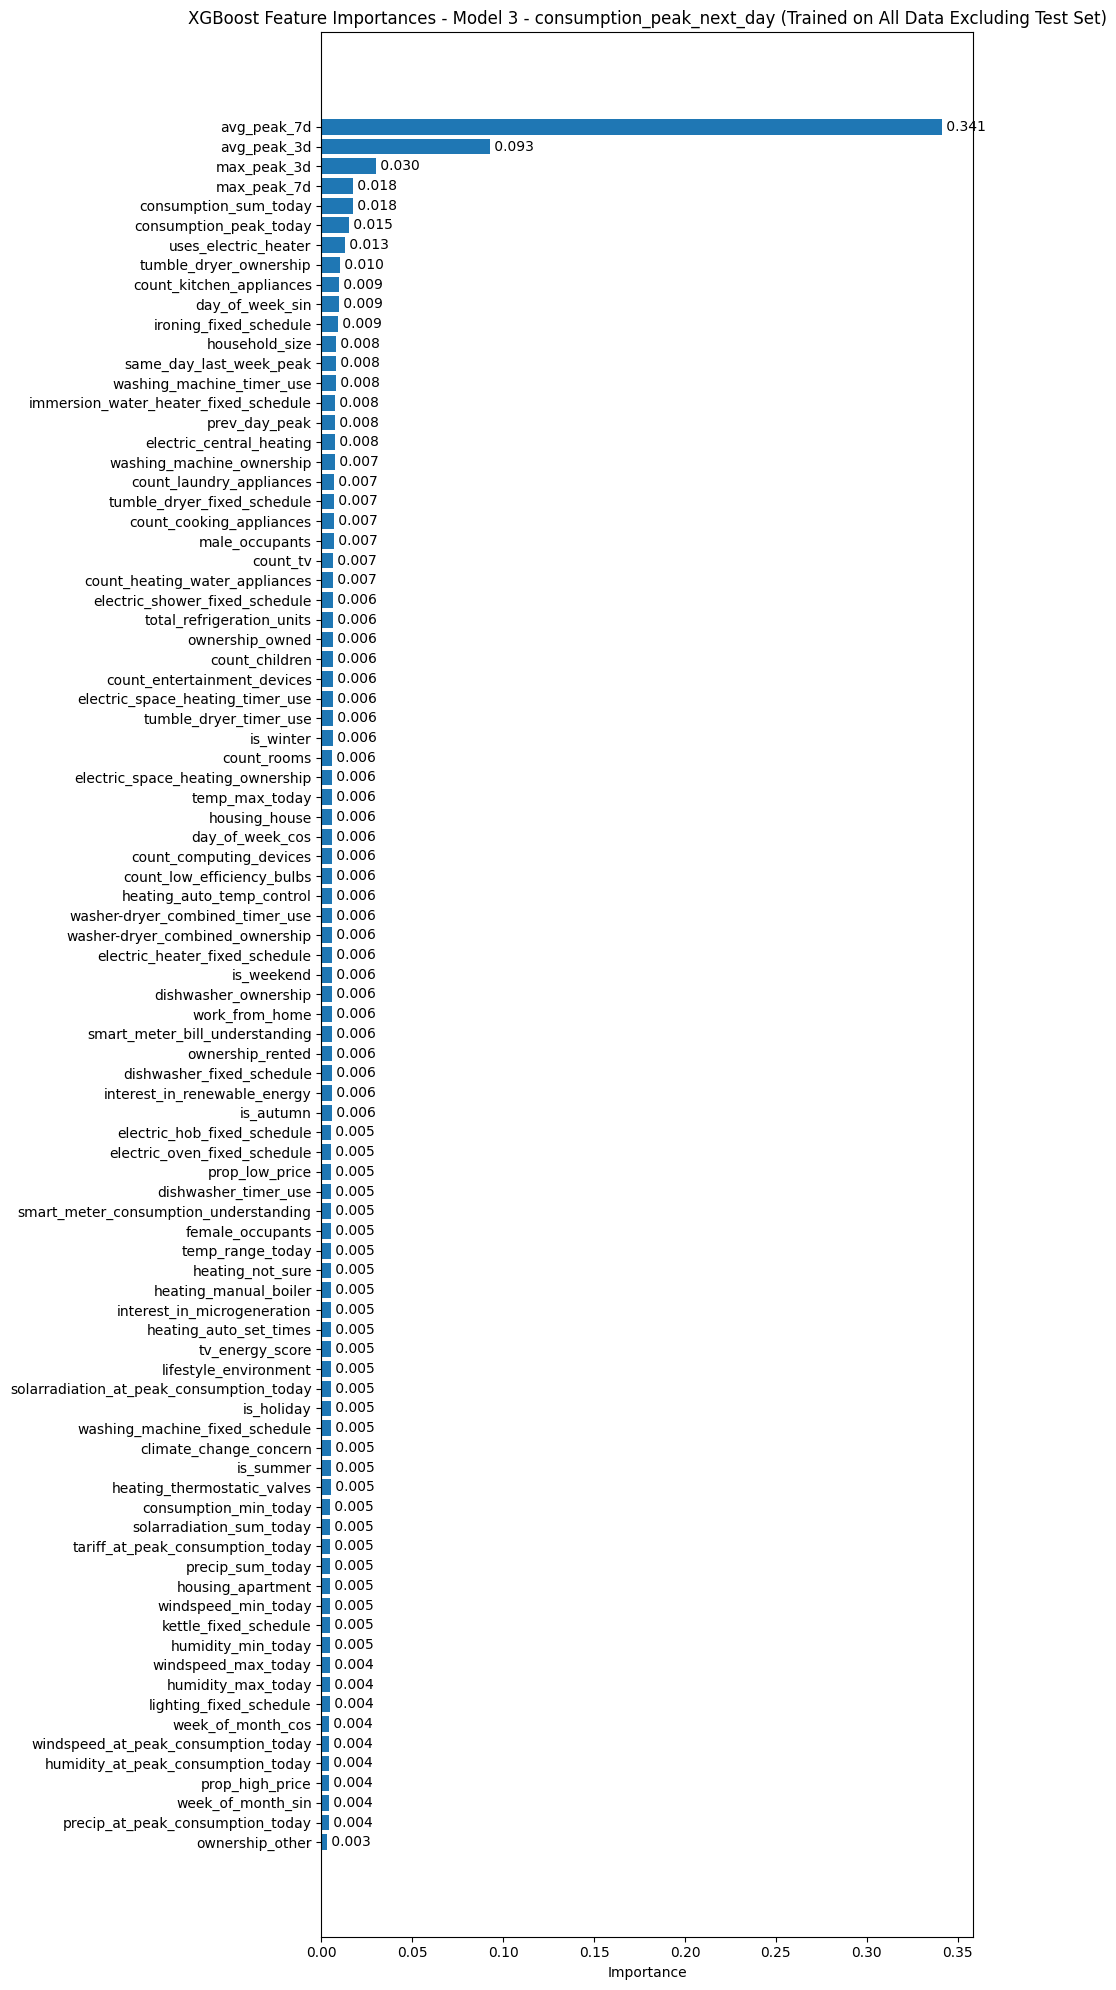

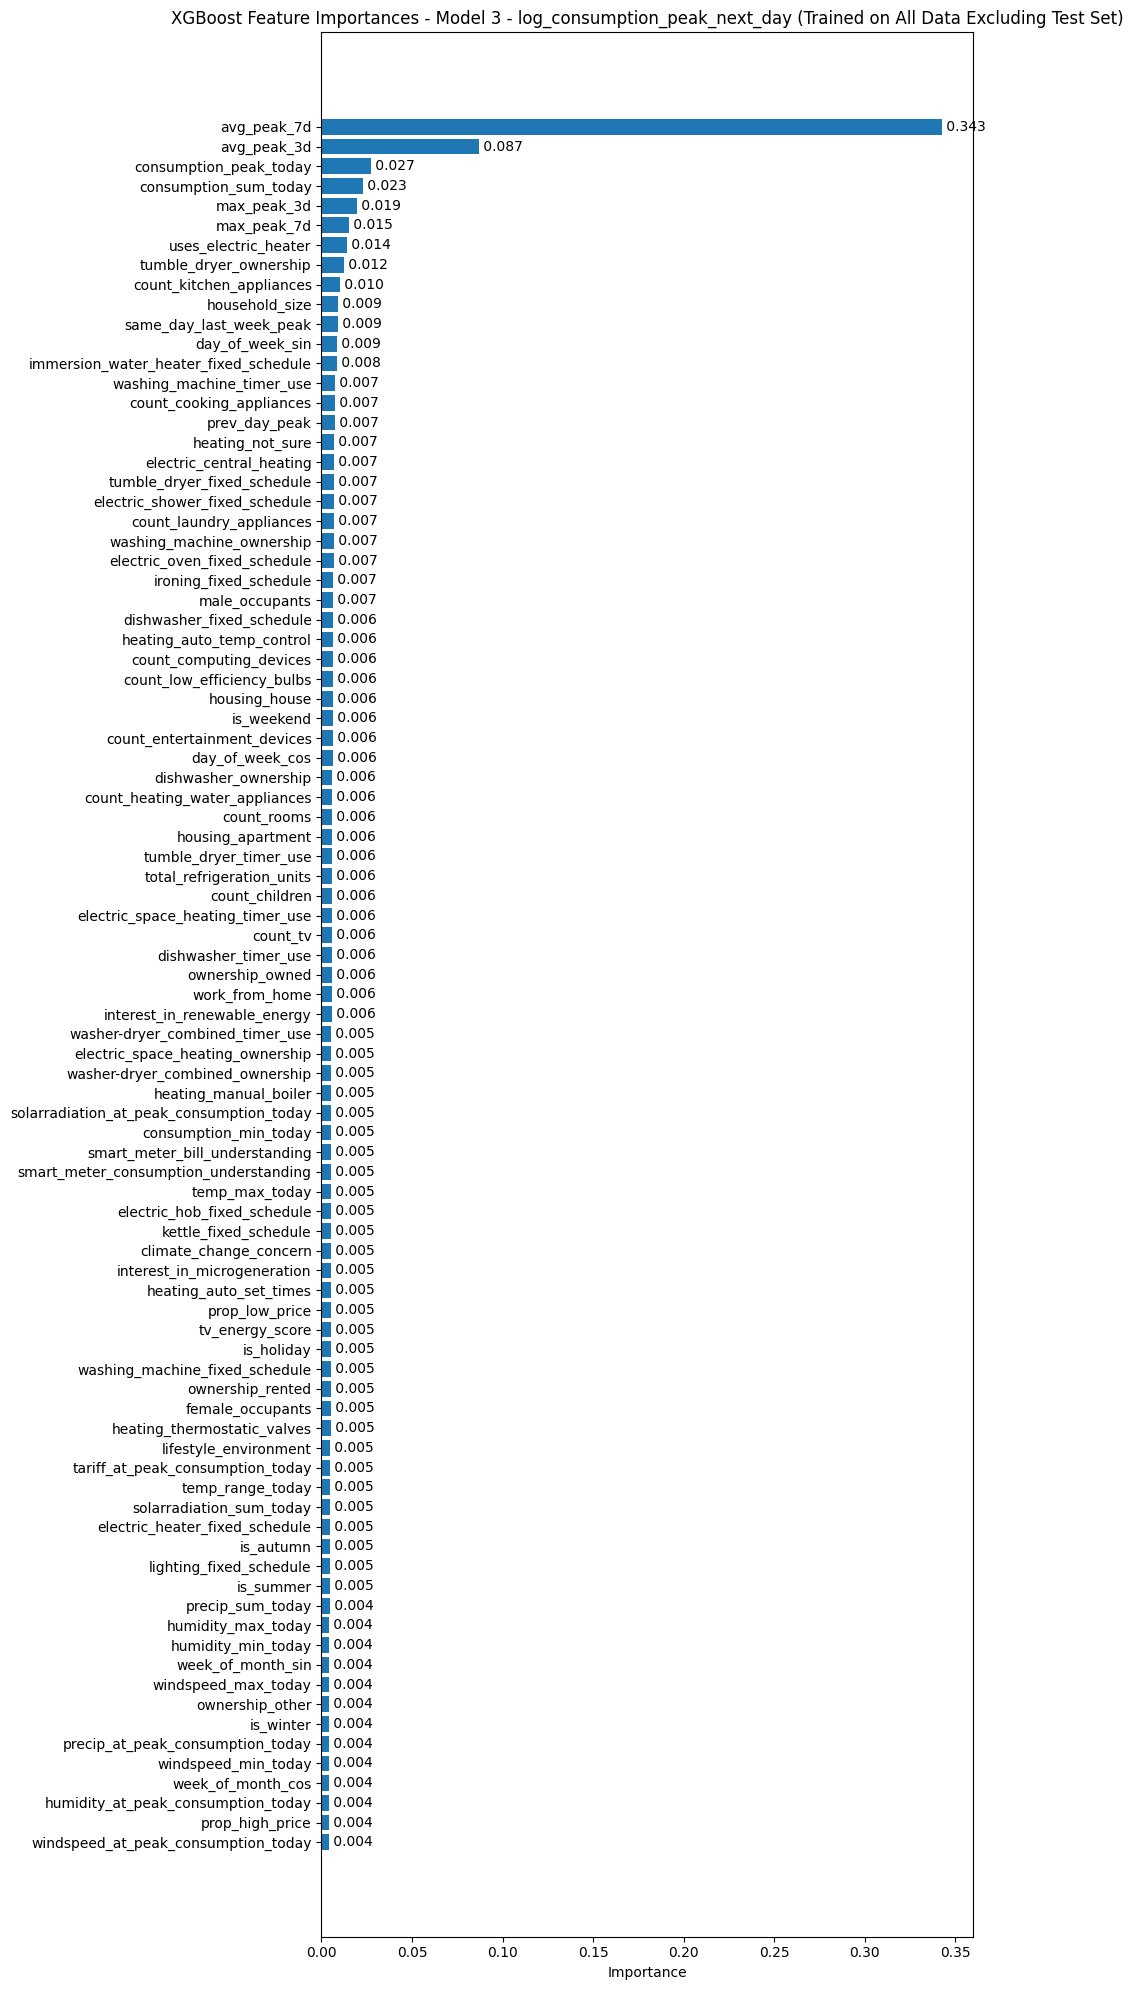

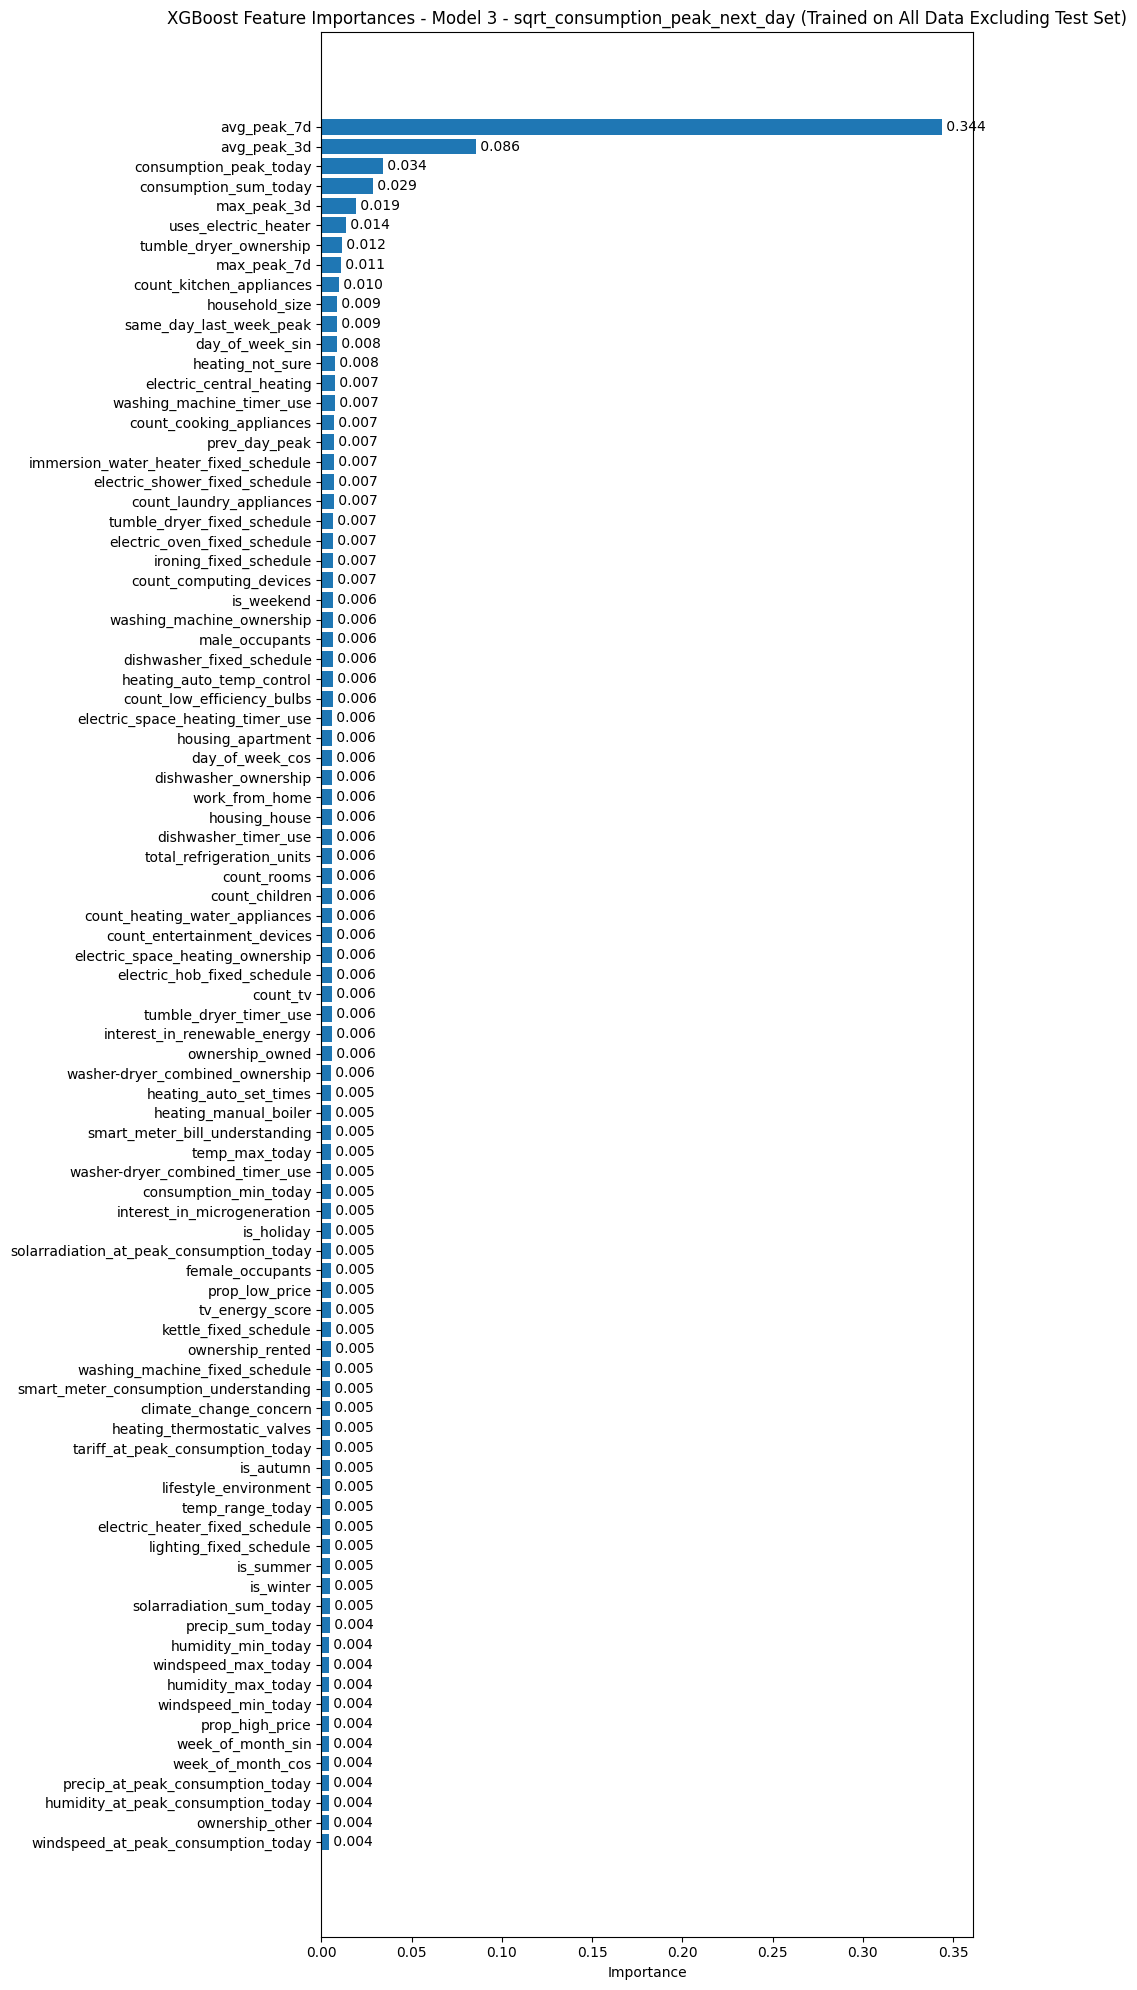

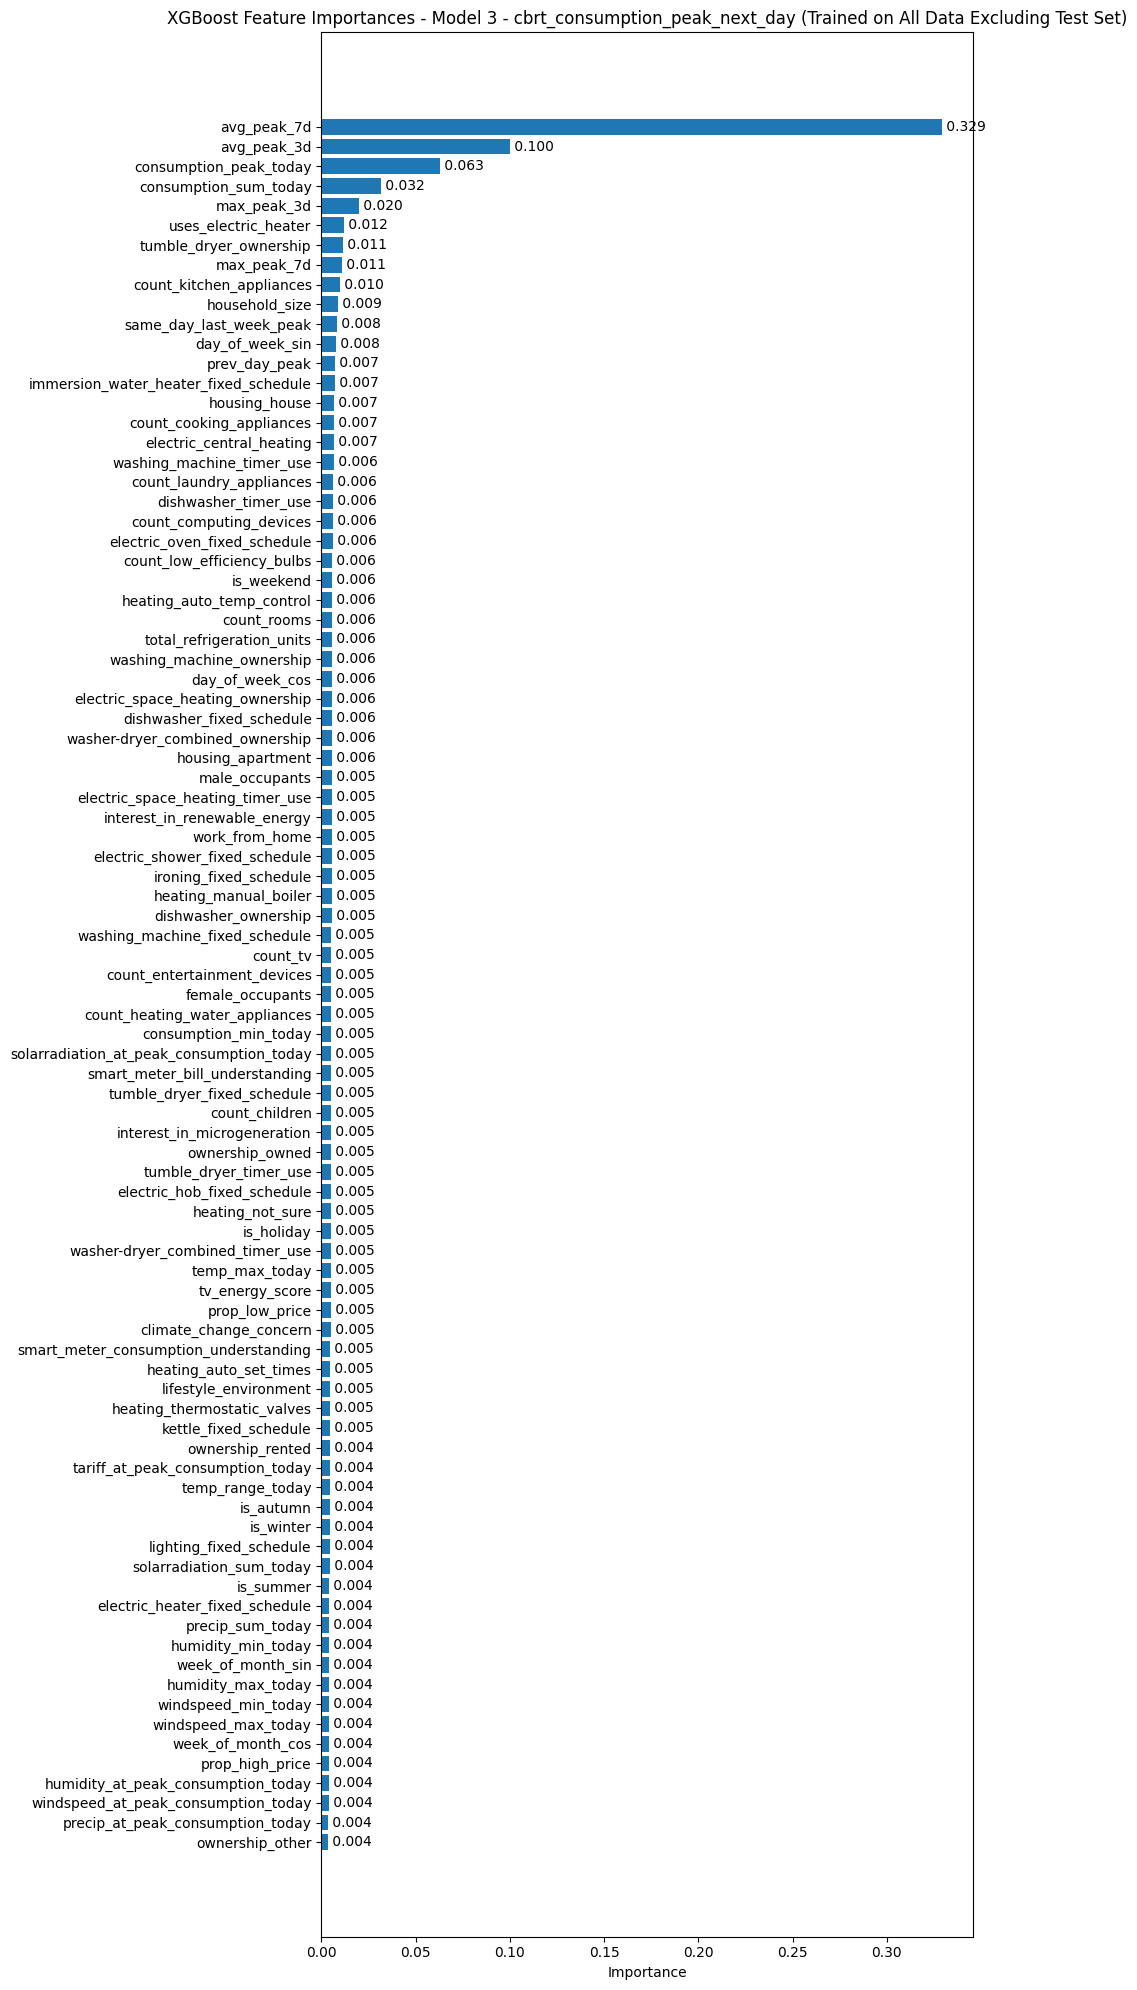


--- Running Model 4 (Only Top 15 Features from Model 3) ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30

Target: consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3454
MAPE: 58.9248%
WAPE: 30.8186%
R²: 0.6788
Validation metrics for fold 1:
MAE: 0.3369
MAPE: 67.1090%
WAPE: 33.1734%
R²: 0.6020
Top 15 Feature importances:
avg_peak_7d: 0.586
avg_peak_3d: 0.219
max_peak_7d: 0.047
consumption_sum_today: 0.028
consumption_peak_today: 0.018
same_day_last_week_peak: 0.014
uses_electric_heater: 0.013
tumble_dryer_ownership: 0.012
ironing_fixed_schedule: 0.011
count_kitchen_appliances: 0.010
day_of_week_sin: 0.009
immersion_water_heater_fixed_schedule: 0.009
washing_machine_timer_use: 0.008
household_size: 0.008
max_peak_3d: 0.008



Target: log_consumption_peak_next_day
Training metrics for fold 1:
MAE: 0.3132
MAPE: 45.4596%
WAPE: 27.9432%
R²: 0.7257
Validation metrics for fold 1:
MAE: 0.3295
MAPE: 54.8598%
WAPE: 32.4477%
R²: 0.5995


c:\Users\RaiN\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training metrics for fold 2:
MAE: 0.3272
MAPE: 42.0079%
WAPE: 29.5076%
R²: 0.6819
Validation metrics for fold 2:
MAE: 0.3442
MAPE: 46.8225%
WAPE: 31.2482%
R²: 0.5754
Top 15 Feature importances:
avg_peak_7d: 0.426
avg_peak_3d: 0.186
consumption_peak_today: 0.110
consumption_sum_today: 0.094
max_peak_7d: 0.039
max_peak_3d: 0.024
uses_electric_heater: 0.018
same_day_last_week_peak: 0.016
tumble_dryer_ownership: 0.015
count_kitchen_appliances: 0.014
immersion_water_heater_fixed_schedule: 0.014
household_size: 0.013
day_of_week_sin: 0.011
washing_machine_timer_use: 0.010
ironing_fixed_schedule: 0.009


Fold 3
Training period: 2013-01-08 to 2013-10-31
Validation period: 2013-11-01 to 2013-11-30

Target: consumption_peak_next_day
Training metrics for fold 3:
MAE: 0.3281
MAPE: 55.6467%
WAPE: 29.6047%
R²: 0.7051
Validation metrics for fold 3:
MAE: 0.3790
MAPE: 52.0685%
WAPE: 30.1865%
R²: 0.6209
Top 15 Feature importances:
avg_peak_7d: 0.547
avg_peak_3d: 0.183
max_peak_7d: 0.053
consumption_sum_

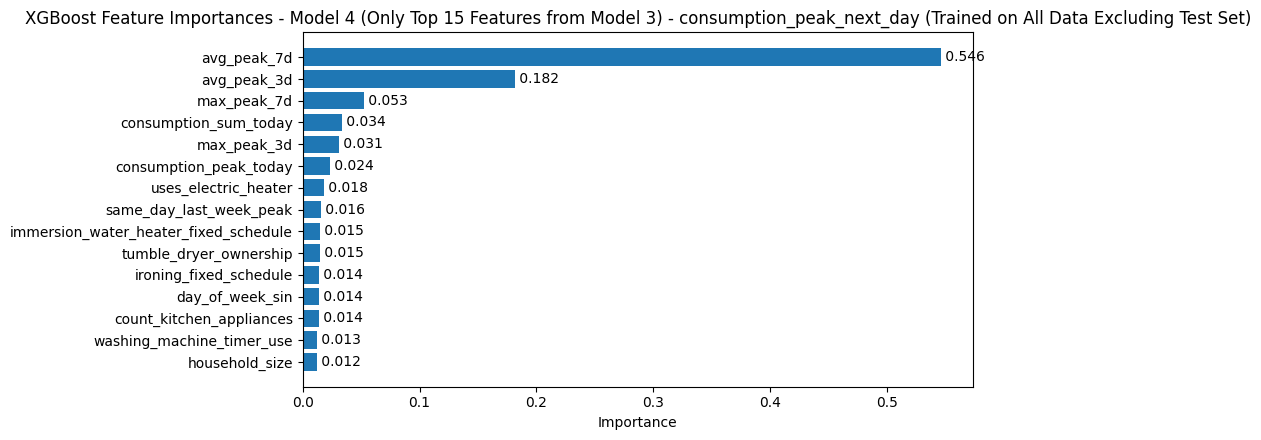

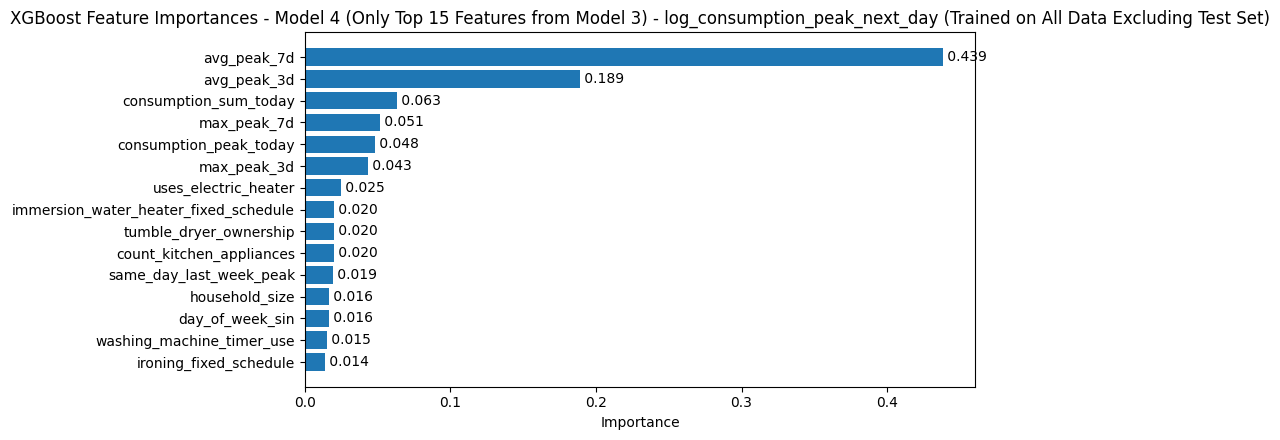

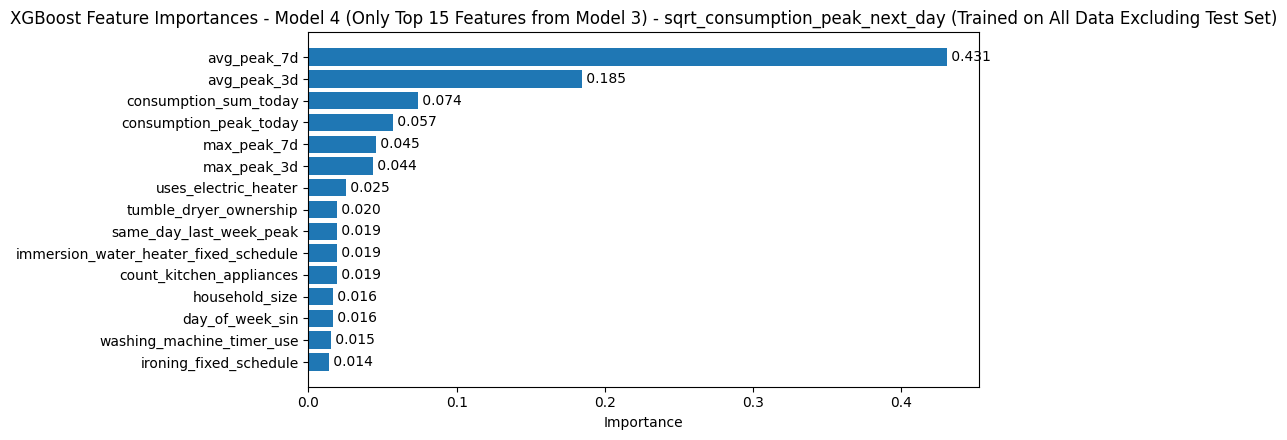

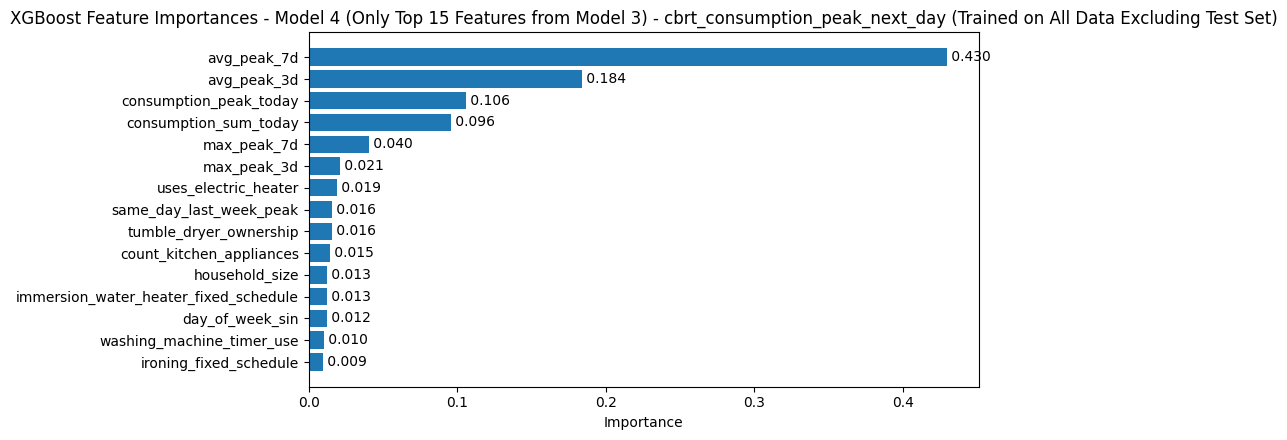


--- Model Comparison ---

--- Test Metrics ---

Model 1:
Number of features: 18

Test metrics for consumption_peak_next_day:
  MAE: 0.3936
  MAPE: 65.0182%
  WAPE: 30.7272%
  R²: 0.6441

Test metrics for log_consumption_peak_next_day:
  MAE: 0.3865
  MAPE: 57.1380%
  WAPE: 30.1728%
  R²: 0.6418

Test metrics for sqrt_consumption_peak_next_day:
  MAE: 0.3860
  MAPE: 50.8990%
  WAPE: 30.1404%
  R²: 0.6411

Test metrics for cbrt_consumption_peak_next_day:
  MAE: 0.3835
  MAPE: 48.6112%
  WAPE: 29.9416%
  R²: 0.6408

Model 2:
Number of features: 30

Test metrics for consumption_peak_next_day:
  MAE: 0.3977
  MAPE: 65.4365%
  WAPE: 31.0477%
  R²: 0.6361

Test metrics for log_consumption_peak_next_day:
  MAE: 0.3912
  MAPE: 56.9194%
  WAPE: 30.5467%
  R²: 0.6314

Test metrics for sqrt_consumption_peak_next_day:
  MAE: 0.3887
  MAPE: 52.0977%
  WAPE: 30.3478%
  R²: 0.6353

Test metrics for cbrt_consumption_peak_next_day:
  MAE: 0.3865
  MAPE: 49.6987%
  WAPE: 30.1740%
  R²: 0.6340

Model 3:


In [7]:
# Dictionary to store results
all_results = {}

# Run models 1 to 3
for i, features in enumerate([model_1_features, model_2_features, model_3_features], 1):
    model_name = f"Model {i}"
    final_models, test_metrics, final_importances = run_model(features, df, folds, param_grid, model_name)
    all_results[model_name] = {
        'features': features,
        'test_metrics': test_metrics,
        'importances': final_importances
    }

# Let's also train model 4, which only uses the top 15 features from model 3
model_4_features = [feature for feature, importance in sorted(all_results['Model 3']['importances']['consumption_peak_next_day'].items(), key=lambda x: x[1], reverse=True)[:15]]
model_4, metrics_4, importances_4 = run_model(model_4_features, df, folds, param_grid, "Model 4 (Only Top 15 Features from Model 3)")

all_results["Model 4"] = {
    'features': model_4_features,
    'test_metrics': metrics_4,
    'importances': importances_4,
    'final_models': model_4
}

# Compare the models
print("\n--- Model Comparison ---")
print("\n--- Test Metrics ---")
for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print(f"Number of features: {len(results['features'])}")
    for target, metrics in results['test_metrics'].items():
        print(f"\nTest metrics for {target}:")
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  MAPE: {metrics['mape']:.4f}%")
        print(f"  WAPE: {metrics['wape']:.4f}%")
        print(f"  R²: {metrics['r2']:.4f}")

print("\n--- Feature Importances ---")
for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    for target in ['consumption_peak_next_day', 'log_consumption_peak_next_day', 
                   'sqrt_consumption_peak_next_day', 'cbrt_consumption_peak_next_day']:
        if target in results['importances']:
            print(f"\n{target}:")
            importances = results['importances'][target]
            sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:15]
            for feature, importance in sorted_importances:
                print(f"{feature}: {importance:.3f}")

In [8]:
# Get the best hyperparameters for the cube root transformation of Model 4 (the best performing model)
best_params_cbrt_model4 = model_4['cbrt_consumption_peak_next_day'].get_params()
# Filter only the tuned hyperparameters
tuned_params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma', 'reg_alpha', 'reg_lambda']

print("\nBest tuned hyperparameters for cube root transformation of Model 4:")
for param in tuned_params:
    print(f"{param}: {best_params_cbrt_model4[param]}")


Best tuned hyperparameters for cube root transformation of Model 4:
n_estimators: 1270
max_depth: 8
learning_rate: 0.018057171166114286
subsample: 0.7390362533589154
colsample_bytree: 0.7292919068542159
min_child_weight: 5
gamma: 0.05667096138379524
reg_alpha: 0.45240482674645155
reg_lambda: 0.4500867470007611
